#HW2 - Algorithm Implementation and Basic Model Selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.spatial import distance
from scipy.stats import mode

## Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls 'gdrive/MyDrive/Technion/Machine Learning/Major HW 2'
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Technion/Machine Learning/Major HW 2')

Major_HW2.ipynb  prepare.py  __pycache__  unnormed_prepare.py  virus_data.csv


In [4]:
filename = '/content/gdrive/MyDrive/Technion/Machine Learning/Major HW 2/virus_data.csv'

In [5]:
# !rm *.csv

# from google.colab import files
# print("Please load the raw csv data")
# uploadedData = files.upload()
# filename = list(uploadedData)[0]

In [6]:
dataset = pd.read_csv(filename)

In [7]:
dataset.shape

(3000, 29)

#<u>**Import the Data Preperation Pipeline**</u>

In [8]:
from unnormed_prepare import prepare_data

#<u>**Preliminary: Data Loading**</u>

In [9]:
train_dirty, test_dirty = train_test_split(dataset, test_size=0.2, random_state=10)
train_dirty.reset_index(inplace=True)
test_dirty.reset_index(inplace=True)
train = prepare_data(train_dirty, train_dirty) 
test = prepare_data(test_dirty, train_dirty)

#<u>**Part 1: k-Nearest Neighbors** (model implementation and selection)</u>

##**<u>Implementation</u>**

**<u>Task:</u>** Implement k-NN estimator using the code template below (don’t change method signatures):
Tip: Read about scipy…cdist, np.copy, and np.argsort (or even better: np.argpartition).
Avoid using for loops.

In [10]:
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors: int = 5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.train_x = np.array(X)
        self.train_y = np.array(y)
        return self

    def predict(self, target_x):
        # Note: You can use self.n_neighbors here
        dist_mat = distance.cdist(target_x, self.train_x, 'euclidean')
        ind = np.argpartition(dist_mat, self.n_neighbors, axis=1)
        predictions = mode(self.train_y[ind][:, :self.n_neighbors], axis=1)[0].flatten()
        return predictions


## **<u>Verifying the Implementation</u>**

In [11]:
def visualize_clf(clf, X, Y, title, marker_size=250):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["P", "v"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(range(n_classes), palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

###**<u>Q1<u>**

Use the following code snippet to generate a toy dataset. Use the sum of the last digit of your i.d and your partner’s i.d for `random_state` (as in HW1).


```
X_toy, y_toy = make_classification(n_samples=100, n_features=2, random_state=10, flip_y = 0.1, n_informative=2, n_redundant=0)
```

Use the provided `visualize_clf` function to visualize the decision boundaries of your model. To your report, attach the plots for k=1 and k=9 on the generated set.</br>
Compare these two learned models from a learning perspective (e.g., overfitting vs. underfitting).

In [12]:
X_toy, y_toy = make_classification(n_samples=100, n_features=2, random_state=10, flip_y = 0.1, n_informative=2, n_redundant=0)

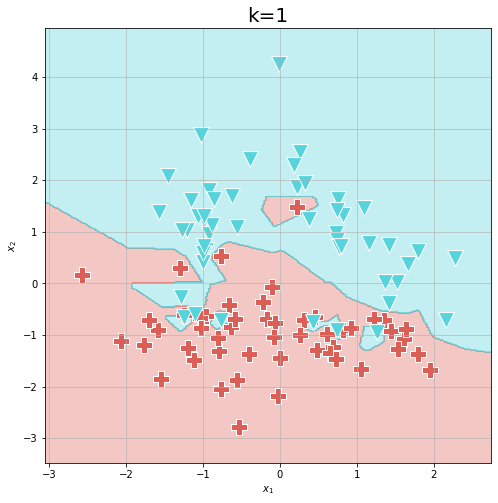

In [13]:
clf = kNN(n_neighbors=1)
clf.fit(X_toy, y_toy)
visualize_clf(clf, X_toy, y_toy, 'k=1', marker_size=250)

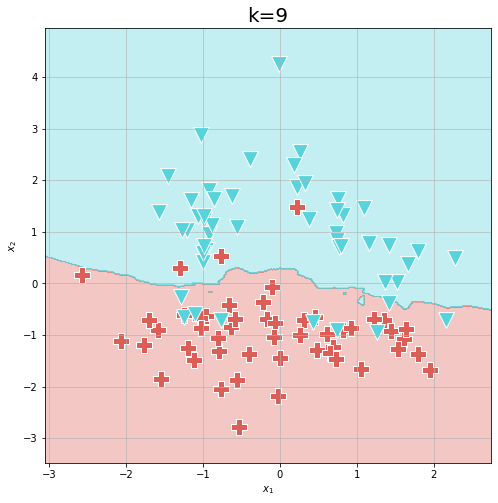

In [14]:
clf = kNN(n_neighbors=9)
clf.fit(X_toy, y_toy)
visualize_clf(clf, X_toy, y_toy, 'k=9', marker_size=250)

## **<u>Some more exploration</u>**

###**<u>Q2<u>**

The following code snippet computes the correlation between `spread` label and the rest of the features. Attach to the report the 10 most correlated features to `spread`.

In [15]:
s = train.corr().spread.abs()
s = pd.Series.filter(s.sort_values(kind="quicksort", ascending=False), regex='[^(spread)&^(risk)&^(covid)]', axis=0)
print(f'The 10 most correlated features to spread are:\n\n{s[:10]}')

The 10 most correlated features to spread are:

PCR_10                 0.151202
household_income       0.048880
blood_A                0.042703
PCR_07                 0.031622
fever                  0.028988
PCR_05                 0.025636
PCR_02                 0.020515
zip_code               0.019663
shortness_of_breath    0.018356
PCR_06                 0.010345
Name: spread, dtype: float64


###**<u>Q3<u>**

Plot a 3d scatterplot using the `PCR_03`, `PCR_07`, and `PCR_10` features (train set only).
Use two different colors to color the points according to their `spread` class.
Add the plot to your report.</br>
**Reminder:** all your plots should have suitable axis labels and titles.

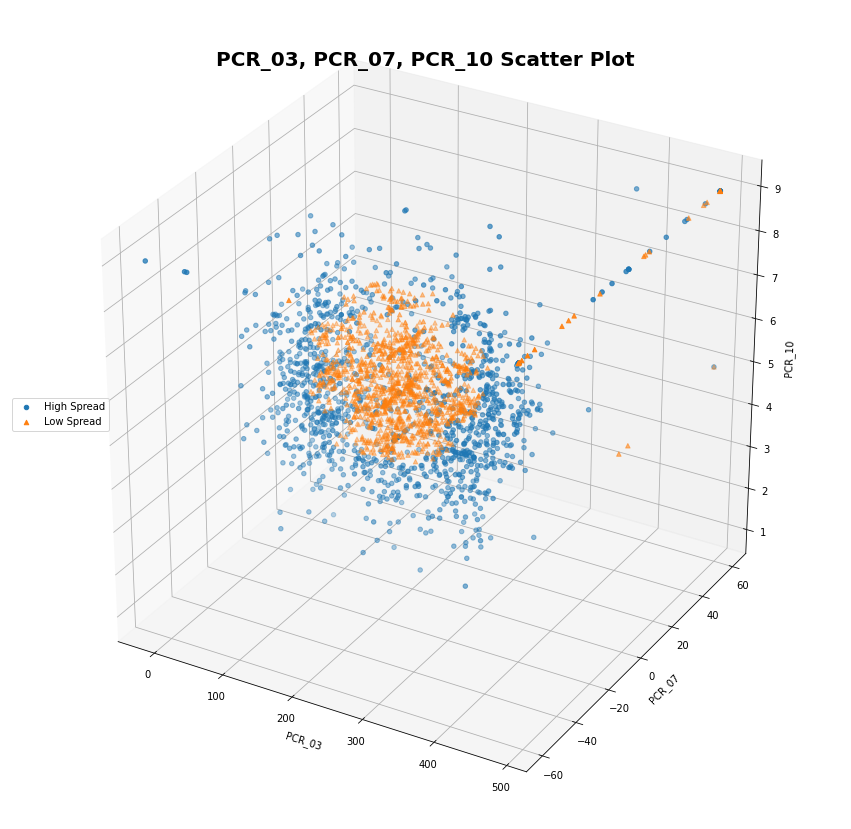

In [16]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(projection='3d')
train_spread = train[train.spread == 1]
train_not_spread = train[train.spread == -1]
scatter1 = ax.scatter(train_spread.PCR_03, train_spread.PCR_07, train_spread.PCR_10, marker='o')
scatter2 = ax.scatter(train_not_spread.PCR_03, train_not_spread.PCR_07, train_not_spread.PCR_10, marker='^')

ax.set_xlabel('PCR_03')
ax.set_ylabel('PCR_07')
ax.set_zlabel('PCR_10')
ax.legend([scatter1, scatter2], ['High Spread', 'Low Spread'], loc='center left')
plt.title('PCR_03, PCR_07, PCR_10 Scatter Plot', fontsize=20, fontweight='bold')
plt.show()

###**<u>Q5<u>**

Train your `k-NN` model with `k=11` on the temporary `DataFrame` to fit the `spread` class. What is the <u>training</u> accuracy?</br>
**Tip:** use `kNN.score` to evaluate the accuracy of your model.

In [17]:
k = 11
train_3710 = train[['PCR_03', 'PCR_07', 'PCR_10']]
clf = kNN(n_neighbors=k)
clf.fit(train_3710, train.spread)
old_score = clf.score(train_3710, train.spread)
print(f'The accuracy of the model with k={k} is {old_score:.6f}.')

The accuracy of the model with k=11 is 0.818333.


###**<u>*Q7*<u>**

Normalize `PCR_03`, `PCR_07`, and `PCR_10` in the temporary `DataFrame` you created. Train a new k-NN model (𝑘=11) on the <u>normalized</u> `DataFrame` like in (Q5).</br>
What is the updated training accuracy? Compare your results to (Q5) results. Can you explain the difference in accuracies?

<u>**Solution:**</u></br>
We predict that the normalization technique that will bring about a better score would be the standardization technique as we already know that the features `PCR_03, PCR_07, PCR_10` follow a normal distribution approximately.</br>
In the following code snippet we will verify this speculation.

In [18]:
norm = MinMaxScaler()
std = StandardScaler()

norm.fit(train_3710)
std.fit(train_3710)

train_3710_norm = norm.transform(train_3710)
train_3710_std = std.transform(train_3710)

In [19]:
clf = kNN(n_neighbors=11)
clf.fit(train_3710_norm, train.spread)
norm_score = clf.score(train_3710_norm, train.spread)

clf.fit(train_3710_std, train.spread)
std_score = clf.score(train_3710_std, train.spread)

print(f'The score with normalization is {norm_score:.6f}.\nThe score with standardization is {std_score:.6f}.\n\nThe old score without any normalization was {old_score:.6f}.')

The score with normalization is 0.920833.
The score with standardization is 0.923333.

The old score without any normalization was 0.818333.


###**<u>Q8<u>**

Choose two features that you decided to normalize (other than `PCR_03, 07, 10`), one with Z-score and one with min-max scaling and explain (in no more than 4 sentences each) why you chose that normalization method for each of these two features. In your report, include the histogram plots of these features before and after the transformation.

Before:


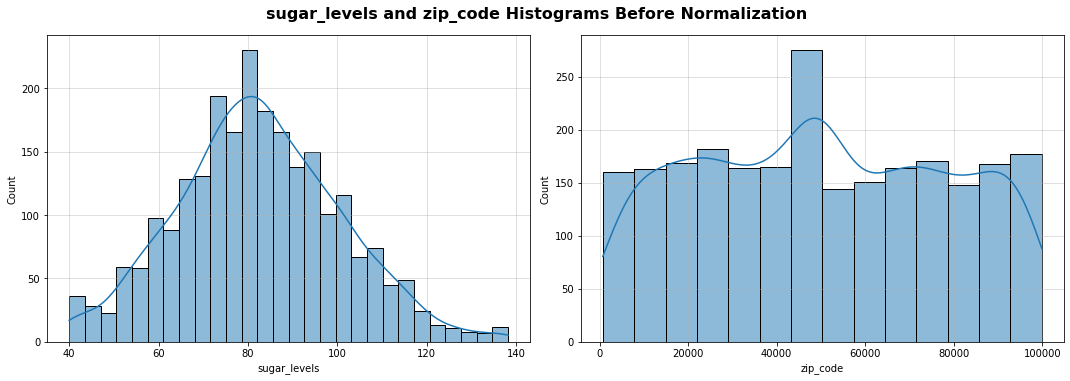

In [20]:
print("Before:")
COLS = 2
ROWS = 1
fig = plt.figure(figsize=(15,5))
fig.suptitle('sugar_levels and zip_code Histograms Before Normalization', fontsize=16, y=1.05, fontweight='bold')
plt.subplot(ROWS,COLS,1)
sns.histplot(data=train, x='sugar_levels', kde=True, palette='colorblind')
plt.grid(alpha=0.5)
plt.subplot(ROWS,COLS,2)
sns.histplot(data=train, x='zip_code', kde=True, palette='colorblind')
plt.grid(alpha=0.5)
plt.tight_layout()

Now we will load the new preperation pipe that also normalizes the values and then create new histograms.

In [21]:
from prepare import prepare_data
train = prepare_data(train_dirty, train_dirty) 
test = prepare_data(test_dirty, train_dirty)

After:


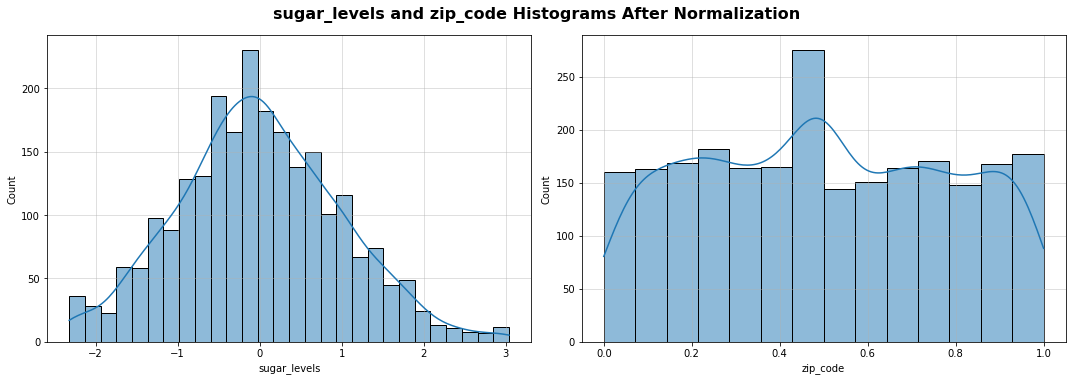

In [22]:
print("After:")
COLS = 2
ROWS = 1
fig = plt.figure(figsize=(15,5))
fig.suptitle('sugar_levels and zip_code Histograms After Normalization', fontsize=16, y=1.05, fontweight='bold')
plt.subplot(ROWS,COLS,1)
sns.histplot(data=train, x='sugar_levels', kde=True, palette='colorblind')
plt.grid(alpha=0.5)
plt.subplot(ROWS,COLS,2)
sns.histplot(data=train, x='zip_code', kde=True, palette='colorblind')
plt.grid(alpha=0.5)
plt.tight_layout()

## **<u>Model Selection (hyperparameter tuning)</u>**

###**<u>Q9<u>**

Use sklearn.model_selection.cross_validate to find the best 𝑘 (neighbours) value in `range(1,61,2)` for predicting the `spread` class with the 3 features we isolated in the normalized temporary `DataFrame` from (Q7).
Use the (default) accuracy metric and 8-folds to perform cross-validation.
Using the outputs of `cross_validate`, plot a validation curve, i.e., the (mean) training and validation accuracies (y-axis) as a function of the 𝑘 values (x-axis).</br>
Add the plot to your report.
Explain: which 𝑘 value is the best? What are its mean training and validation accuracies?

In [23]:
val_scores = dict()
train_scores = dict()
train_3710 = train[['PCR_03', 'PCR_07', 'PCR_10']]

for k in range(1,61,2):
  clf = kNN(n_neighbors=k)
  res = cross_validate(clf, X=train_3710, y = np.array(train.spread), cv = 8, scoring='accuracy', n_jobs = -1, return_train_score = True)
  val_scores[k] = res['test_score'].mean()
  train_scores[k] = res['train_score'].mean()

to_plot = pd.DataFrame(data={'k': train_scores.keys(), 'Validation Accuracy': [val for _, val in val_scores.items()], 'Training Accuracy': [val for _, val in train_scores.items()]})
to_plot

dict_items([(1, 0.9919642857142857), (3, 0.9458333333333333), (5, 0.9342857142857143), (7, 0.9286309523809524), (9, 0.9251785714285714), (11, 0.9207142857142856), (13, 0.9205952380952381), (15, 0.9180952380952381), (17, 0.9160714285714285), (19, 0.9148214285714286), (21, 0.9130952380952381), (23, 0.911845238095238), (25, 0.9088690476190476), (27, 0.9075595238095238), (29, 0.9052976190476191), (31, 0.9034523809523809), (33, 0.9023214285714286), (35, 0.9002380952380953), (37, 0.8977380952380952), (39, 0.8963095238095238), (41, 0.89375), (43, 0.8922619047619048), (45, 0.8910119047619047), (47, 0.8901190476190477), (49, 0.8873809523809524), (51, 0.8849404761904762), (53, 0.88375), (55, 0.8825), (57, 0.8816071428571428), (59, 0.8813095238095239)])

Text(0.5, 1.0, 'kNN Validation Curve')

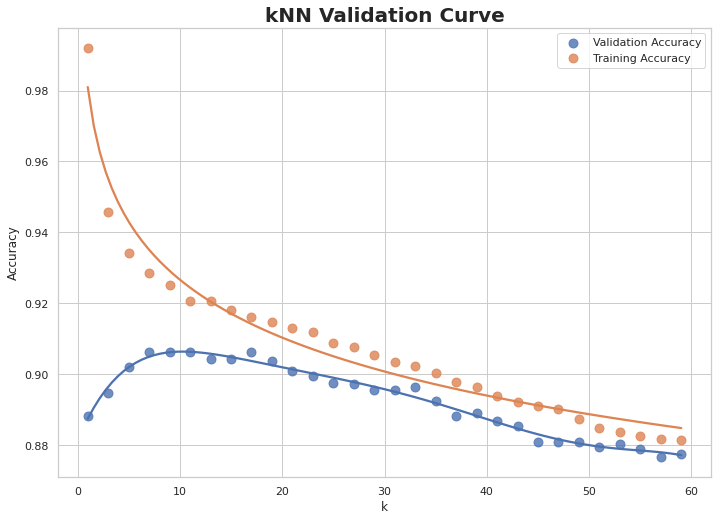

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
ax1 = sns.regplot(x="k", y="Validation Accuracy", data=to_plot,
                 scatter_kws={"s": 80},
                 order=6, ci=None, label='Validation Accuracy')
sns.regplot(x="k", y="Training Accuracy", data=to_plot,
                 scatter_kws={"s": 80},
                 logx=True, ci=None, label='Training Accuracy', ax=ax1)
ax1.set(xlabel='k', ylabel='Accuracy')
ax1.legend()
plt.title('kNN Validation Curve', fontsize=20, fontweight='bold')

## **<u>Error analysis</u>**

###**<u>Q10<u>**

Using the optimal hyperparameter value, compute a cross-validated $2×2$ confusion matrix for the `spread` class. Fill and attach an appropriate table to your report.</br>
Does your model tend more to false positives / false negatives?

In [ ]:
clf = kNN(n_neighbors=11)
y_pred = cross_val_predict(clf, X=train_3710, y = np.array(train.spread), cv = 8, n_jobs = -1)
conf_mat = confusion_matrix(train.spread, y_pred)
conf_mat

array([[1107,   83],
       [ 142, 1068]])

#<u>**Part 2: Decision trees** (model visualization and selection)</u>

## **<u>Visualization and basic analysis</u>**

###**<u>Q11<u>**

Return to your report / notebook for HW1. Based on your analysis in HW1, name 3 features that seemed important for predicting the risk class. Attach the corresponding plots that made you believe these features are indeed important.

<u>**Solution:**</u></br>
We think that 3 features that seem important for predicting the `risk` class are: `PCR_01, PCR_02, PCR_06`. </br>
We will plot graphs to support our speculation.

Text(0.5, 1.0, 'PCR_01 vs. sugar_levels Scatter Plot')

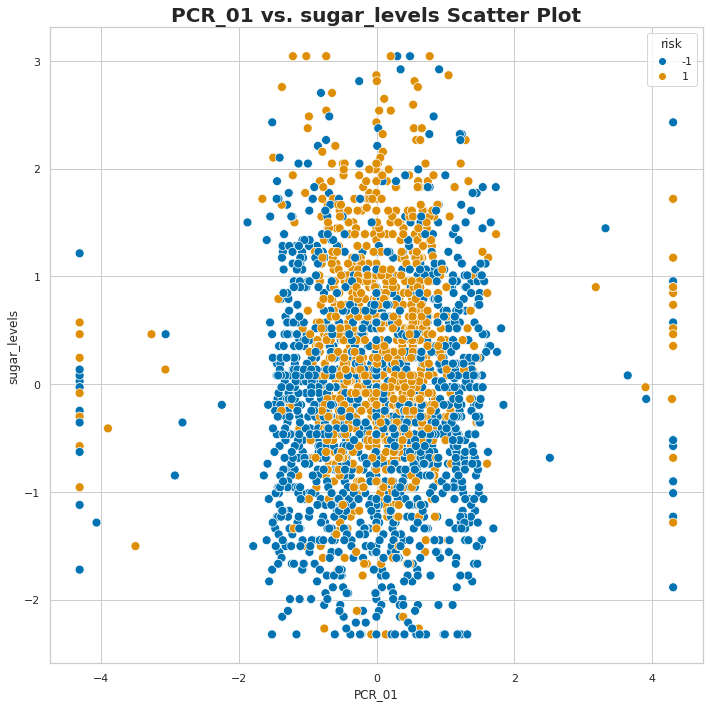

In [ ]:
sns.set(rc={'figure.figsize':(11.7,11.7)})
sns.set_style('whitegrid')
ax1 = sns.scatterplot(x='PCR_01', y='sugar_levels', data=train, 
                      s=80, hue='risk', palette='colorblind')
plt.title('PCR_01 vs. sugar_levels Scatter Plot', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'PCR_02 vs. sugar_levels Scatter Plot')

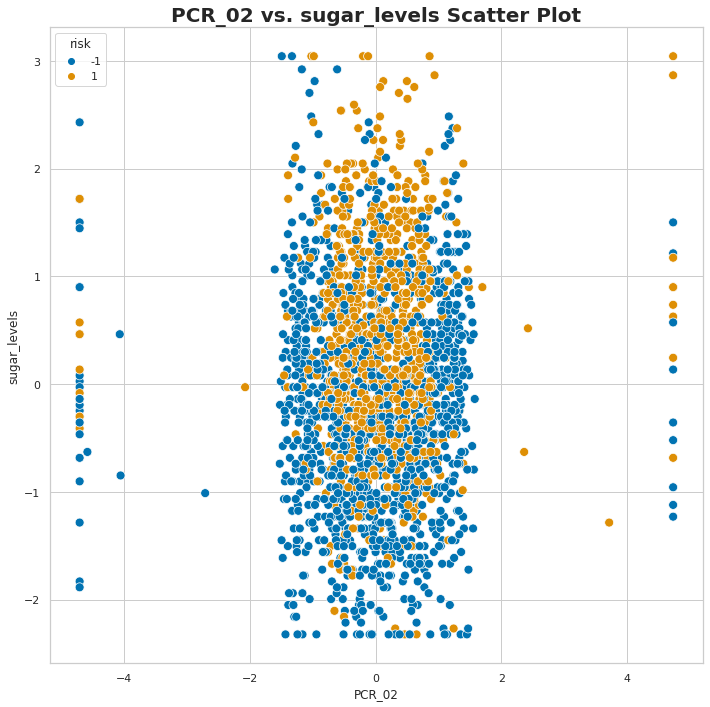

In [ ]:
sns.set(rc={'figure.figsize':(11.7,11.7)})
sns.set_style('whitegrid')
ax1 = sns.scatterplot(x='PCR_02', y='sugar_levels', data=train, 
                      s=80, hue='risk', palette='colorblind')
plt.title('PCR_02 vs. sugar_levels Scatter Plot', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'PCR_01 vs. PCR_02 Scatter Plot')

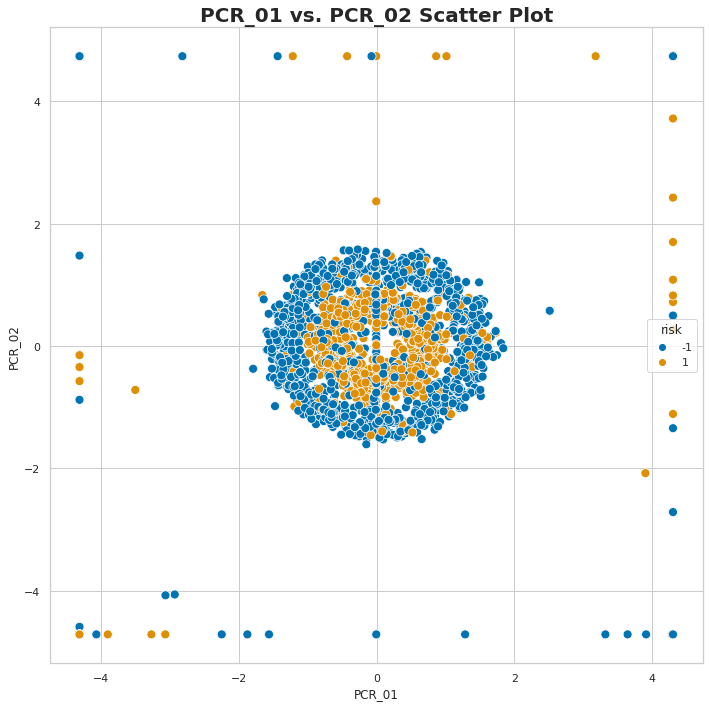

In [ ]:
sns.set(rc={'figure.figsize':(11.7,11.7)})
sns.set_style('whitegrid')
scatter = sns.scatterplot(x='PCR_01', y='PCR_02', data=train, 
                      s=80, hue='risk', palette='colorblind')
plt.title('PCR_01 vs. PCR_02 Scatter Plot', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'sugar_levels KDE Plot')

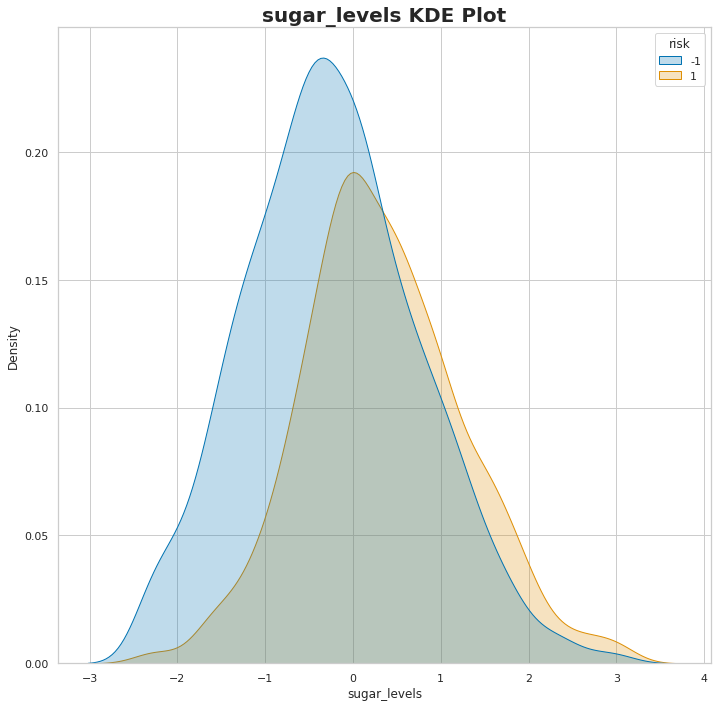

In [ ]:
sns.set(rc={'figure.figsize':(11.7,11.7)})
sns.set_style('whitegrid')
sns.kdeplot(data=train, x="sugar_levels", hue="risk", fill=True, palette='colorblind')
plt.title('sugar_levels KDE Plot', fontsize=20, fontweight='bold')

###**<u>Q12<u>**

Compute the 10 most correlated features to the `risk` class and attach them to your report.

In [ ]:
s = train.corr().risk.abs()
s = pd.Series.filter(s.sort_values(kind="quicksort", ascending=False), regex='[^(spread)&^(risk)&^(covid)]', axis=0)
print(f'The 10 most correlated features to risk are:\n\n{s[:10]}')

The 10 most correlated features to risk are:

sugar_levels           0.281867
PCR_05                 0.215304
PCR_06                 0.177746
zip_code               0.043820
PCR_02                 0.034958
PCR_03                 0.034465
fever                  0.032530
blood_A                0.026378
PCR_01                 0.022421
shortness_of_breath    0.016878
Name: risk, dtype: float64


###**<u>Q13<u>**

Train a model with ID3 and `max_depth=4` (not including the root level).
What is the <u>training</u> accuracy? Visualize the trained tree using plot_tree (provide appropriate `feature/class_names`) and attach the plot to your report.

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
train_featureless = train.drop(labels=['risk', 'spread', 'covid'], axis=1)
clf.fit(X=train_featureless, y=train.risk)
print(f'The training accuracy is {clf.score(train_featureless, train.risk):.5f}.')

The training accuracy is 0.73875.


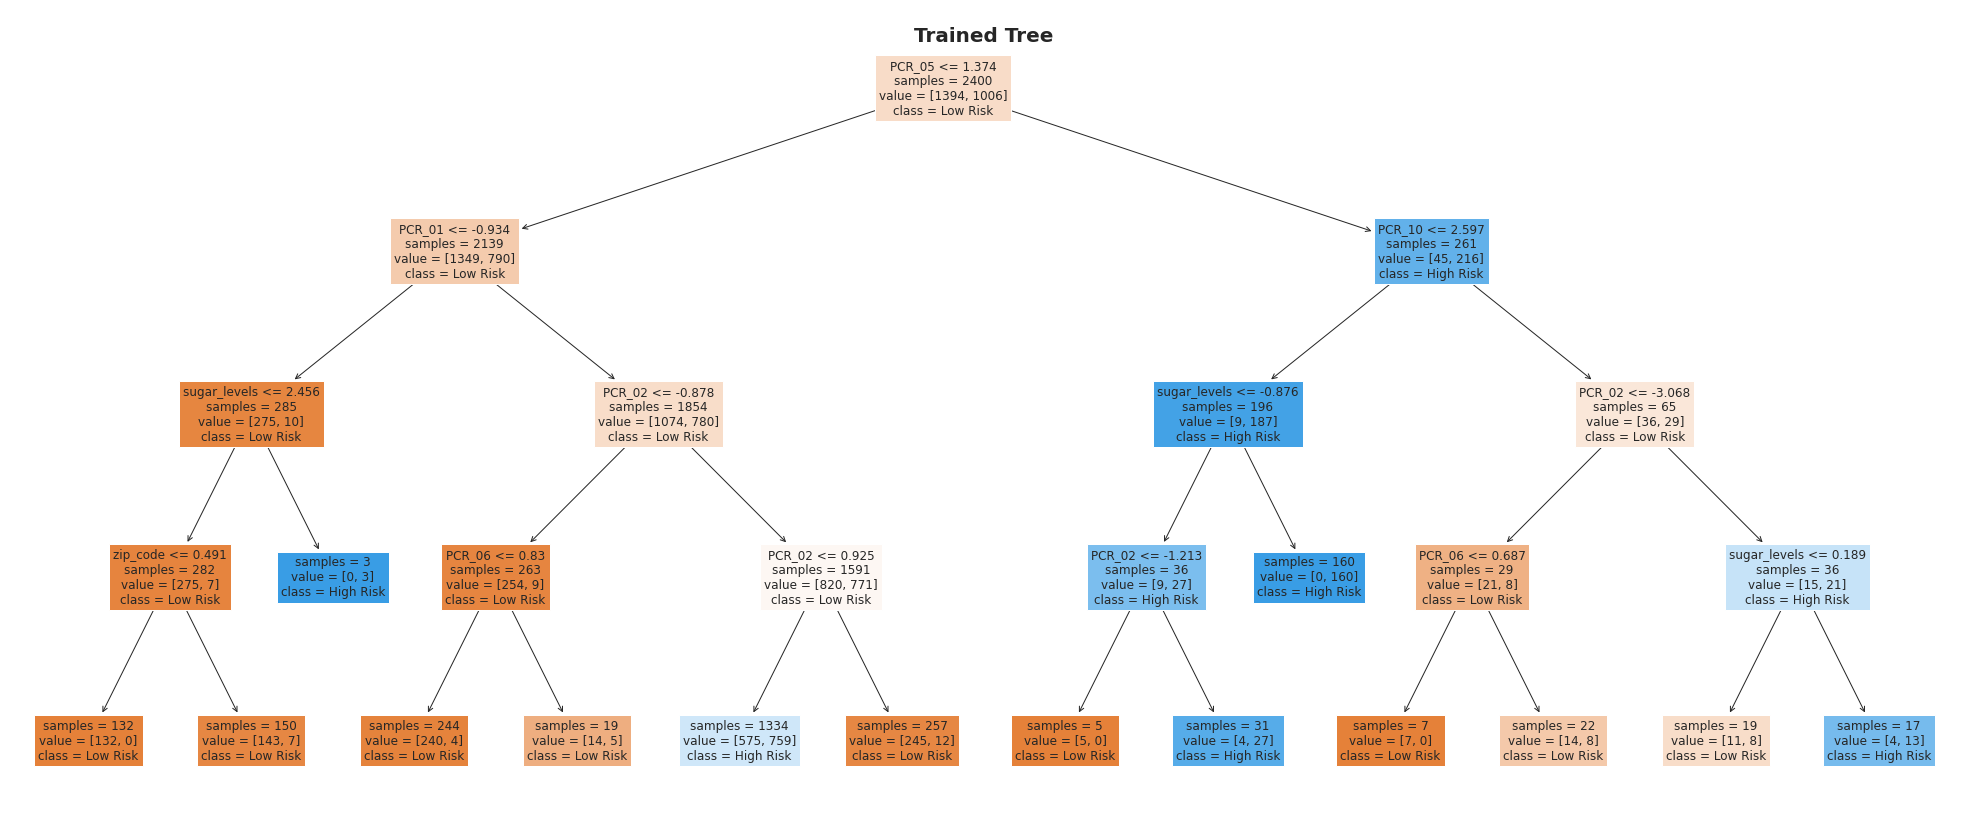

In [ ]:
fig, ax = plt.subplots(figsize=(35,15))
_ = plot_tree(clf, feature_names=train_featureless.columns, class_names=['Low Risk', 'High Risk'], filled=True, impurity=False, fontsize=12, ax=ax)
_ = plt.title('Trained Tree', fontsize=20, fontweight='bold', y=0.95)

###**<u>Q15<u>**

In the DecisionTreeClassifier documentation, read about the `min_samples_leaf` argument and make sure to understand how it can help prevent overfitting.</br>
You will now tune on <u>two</u> hyperparameters <u>simultaneously</u> – both `min_samples_leaf` and `max_depth`. You need to look for the <u>combination</u> of these two hyperparameters that lead to the best validation performance. There are many approaches for tuning multiple hyperparameters, and here we take the <u>grid search</u> approach.
</br></br>
Using 8-fold cross-validation, tune the two aforementioned hyperparameters by performing a grid search (see GridSearchCV).</br>
Find the combination yielding the best validation error for predicting the `risk` class.

In [ ]:
params = {
    'max_depth': list(range(4,24)),
    'min_samples_leaf': list(range(1,22))
}
grid_cv = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), params, cv=8, 
                       return_train_score=True, scoring='accuracy', n_jobs=-1)
grid_cv.fit(train_featureless, train.risk)
print(f'Best cross-validation score: {grid_cv.best_score_:.2f}')
print(f'Best Parameters: {grid_cv.best_params_}')

Best cross-validation score: 0.90
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2}


In [ ]:
# Input: grid_cv.cv_results_, train=False if want to print the validation heatmap
def printTreeGridHeatmap(grid_cv_res, train=False, figsize=None):
  if figsize is not None:
    sns.set(rc={'figure.figsize': figsize})
  table = pd.pivot_table(pd.DataFrame(grid_cv_res), values=('mean_test_score' if not train else 'mean_train_score'), index='param_max_depth', columns='param_min_samples_leaf')
  heat = sns.heatmap(table, annot=True, xticklabels=True)
  heat.invert_yaxis()
  heat.set(xlabel='min_samples_leaf', ylabel='max_depth')
  _ = plt.title('Mean validation accuracy' if not train else 'Mean training accuracy', fontsize=20, fontweight='bold', y=0.95)

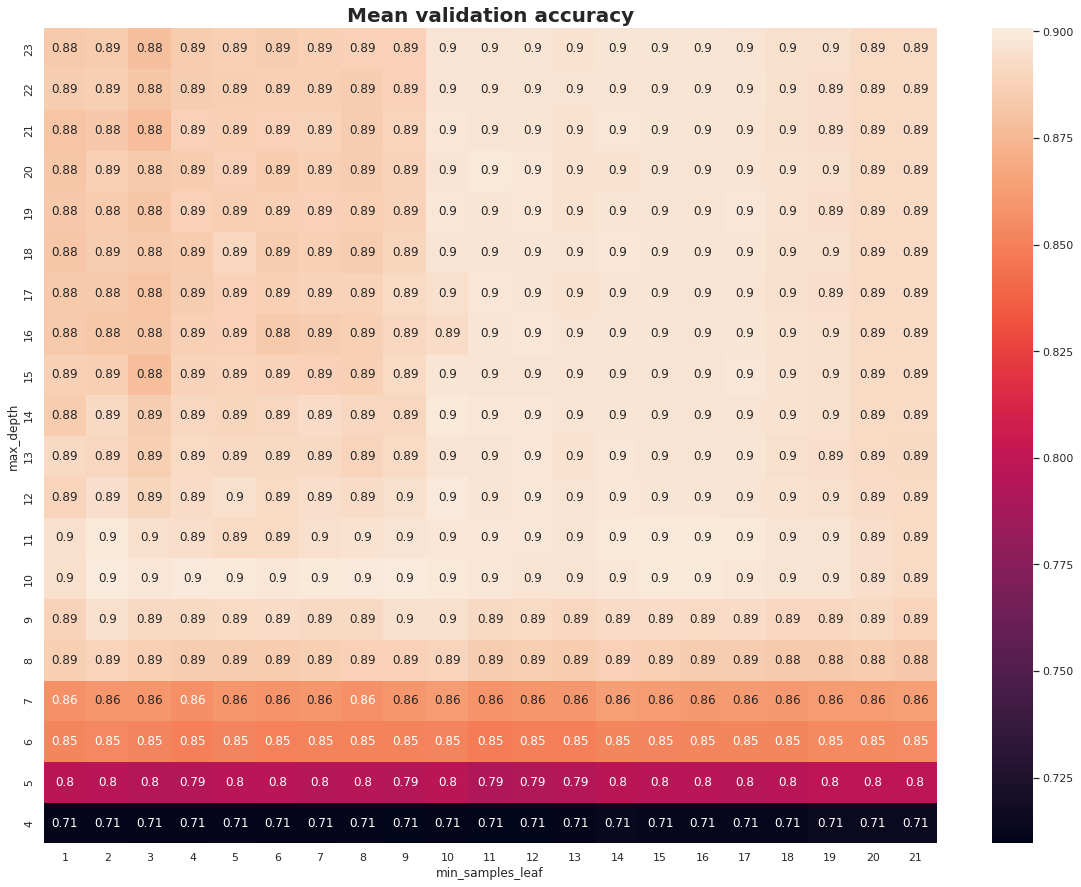

In [ ]:
printTreeGridHeatmap(grid_cv.cv_results_, figsize=(20,15))

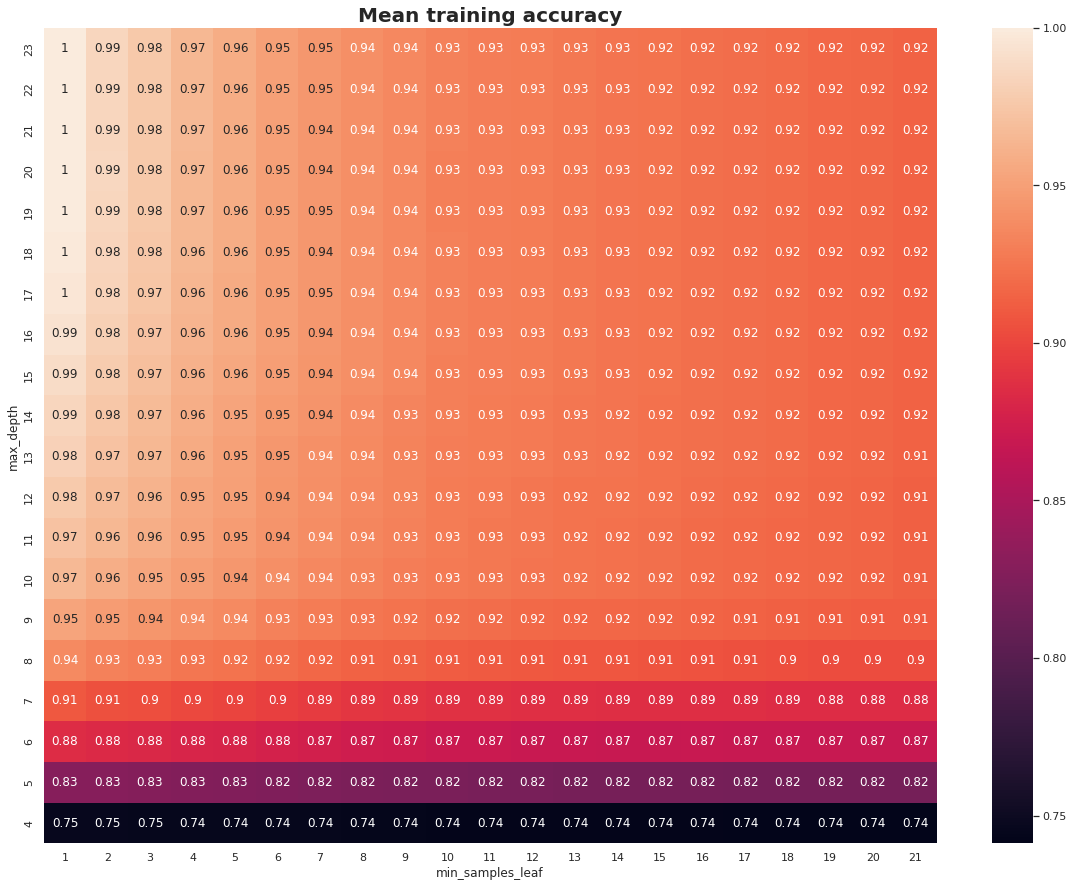

In [ ]:
printTreeGridHeatmap(grid_cv.cv_results_, train=True, figsize=(20,15))

#<u>**Part 3: SVM** (implementation and optimization)</u>

## **<u>Implementation of the loss and its gradient</u>**

In [ ]:
class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """

    def __init__(self, C: float, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        hinge_loss = sum(list(map(lambda x: x if x > 0 else 0,
                         (1 - hinge_inputs).reshape(1, -1)[0])))
        loss = norm*norm + C*hinge_loss
        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        g_w = None
        g_b = 0.0

        # partial_b_inputs: C*f(y * ((X dot w) + b)) * y = C*f(y*margins)*y = C*f(hinge_inputs)*y
        def f_z(x): return list(map(lambda z: -1 if z < 1 else 0, x))

        def cacl_partial_b_inputs(f=f_z):
            '''
            :param f: A function f that gets a vector as input and returns a result vector.
            '''
            margins = (X.dot(w) + b).reshape(-1, 1)
            hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
            return C * np.multiply(f(hinge_inputs), y)

        partial_b_inputs = cacl_partial_b_inputs()
        g_b = sum(partial_b_inputs)

        #    [a, b, c]     *   [[    x1     ],
        #        ^              [    x2     ],  =  a*x1 + b*x2 + c*x3
        #  partial_b_inputs     [    x3     ]]
        X_part = partial_b_inputs.dot(X)
        g_w = 2*w + X_part
        return g_w, g_b



## **<u>Verifying the implementation</u>**

###**<u>Q16<u>**

Using the <u>**normalized**</u> dataset and `covid` as our target, generate a plot that compares the numerical gradients to the analytic gradients.</br>
Do this by running the following command:</br>

```
compare_gradients(X_train, y_train, deltas=np.logspace(-5, -1, 9))
```

In [ ]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel('dist(analytic, numeric$_\delta$)', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


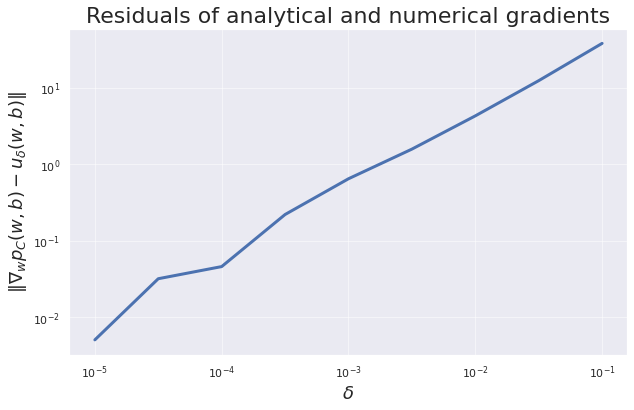

In [ ]:
compare_gradients(np.array(train.drop(['risk', 'spread', 'covid'], axis=1)), np.array(train.covid), deltas=np.logspace(-5, -1, 9))

## **<u>Solving Soft SVM problems using Stochastic Gradient Descent (SGD)</u>**

###**<u>Q17<u>**

Use the following code snippet to train a `SoftSVM` model on the `covid` class (make sure you use the <u>entire normalized</u> training set and `{+1,-1}` labels) and plot a learning curve. You are allowed to slightly change this code if you need to.</br>
Make sure your model <u>converges</u>. For that, you may need to adjust the `lr` and `max_iter` values. However, you may <u>not</u> change the C value.
Make sure to add proper labels for the x-axis and both y-axes.</br>
Add a suitable title and a legend. Finally, add the plot to your report.</br>
What is the maximal training accuracy achieved by your model?

In [ ]:
class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """

    def __init__(self, C: float, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        hinge_loss = sum(list(map(lambda x: x if x > 0 else 0,
                         (1 - hinge_inputs).reshape(1, -1)[0])))
        loss = norm*norm + C*hinge_loss
        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        g_w = None
        g_b = 0.0

        # partial_b_inputs: C*f(y * ((X dot w) + b)) * y = C*f(y*margins)*y = C*f(hinge_inputs)*y
        def f_z(x): return list(map(lambda z: -1 if z < 1 else 0, x))

        def cacl_partial_b_inputs(f=f_z):
            '''
            :param f: A function f that gets a vector as input and returns a result vector.
            '''
            margins = (X.dot(w) + b).reshape(-1, 1)
            hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
            return C * np.multiply(f(hinge_inputs), y)

        partial_b_inputs = cacl_partial_b_inputs()
        g_b = sum(partial_b_inputs)

        #    [a, b, c]     *   [[    x1     ],
        #        ^              [    x2     ],  =  a*x1 + b*x2 + c*x3
        #  partial_b_inputs     [    x3     ]]
        X_part = partial_b_inputs.dot(X)
        g_w = 2*w + X_part
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # Compute the (sub)gradient of the current *batch*
            g_w, g_b = type(self).subgradient(
                self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # update the learned parameters correctly
            self.w = self.w - self.lr*g_w
            self.b = self.b - self.lr*g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
        """
        # compute the predicted labels (+1 or -1)
        def predict_row(xi):
            return 1 if (self.w.dot(xi) + self.b) >= 0 else -1

        y_pred = np.apply_along_axis(predict_row, axis=1, arr=X)
        return y_pred


In [ ]:
clf = SoftSVM(C=1e2, lr=1e-5) 
losses, accuracies = clf.fit_with_logs(np.array(train.drop(['risk', 'spread', 'covid'], axis=1)), np.array(train.covid), max_iter=5000) 


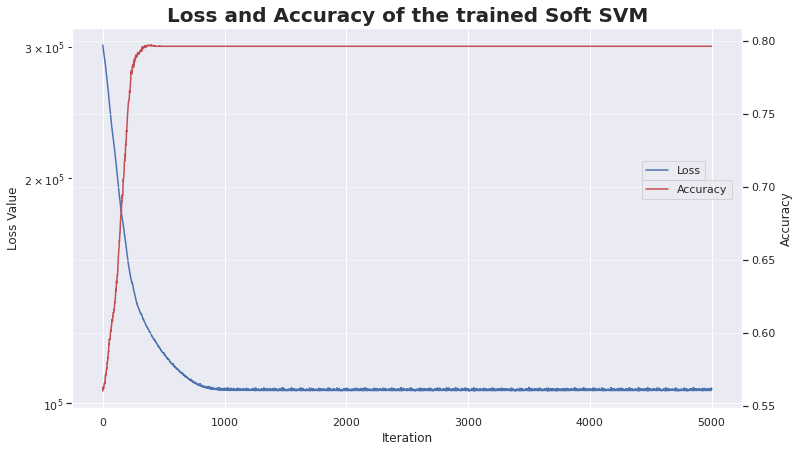

In [ ]:
fig = plt.figure(figsize=(12, 7)) 
ax1 = fig.add_subplot(111) 
line1 = ax1.semilogy(losses, c='b', label='Loss')
ax1.set_ylabel('Loss Value')
ax1.set_xlabel('Iteration')
ax1.legend(loc=(0.85,0.6))
ax2 = ax1.twinx() 
line2 = ax2.plot(accuracies, c='r', label='Accuracy') 
ax2.set_ylabel('Accuracy')
ax2.grid(alpha=0.5) 
ax2.legend(loc=(0.85,0.55))
# plt.legend([line1, line2], ['Loss', 'Accuracy'])
plt.title('Loss and Accuracy of the trained Soft SVM', fontsize=20, fontweight='bold')
plt.show()

In [ ]:
print(f'The maximal training accuracy achieved by our model is {clf.score(np.array(train.drop(["risk", "spread", "covid"], axis=1)), np.array(train.covid))}.')

The maximal training accuracy achieved by our model is 0.79625.


## **<u>Applying a feature mapping</u>**

###**<u>Q18<u>**

Next, we want to train our model to predict the `spread` using the 3-features-dataset from (Q7). Based on the previous analysis, explain why your `SoftSVM` model cannot compete with your `kNN` model (on the `spread` label).

In [ ]:
clf = SoftSVM(C=1e2, lr=1e-6)
clf.fit(np.array(train[['PCR_03', 'PCR_07', 'PCR_10']]), np.array(train.spread), max_iter=5000)
print(f'The maximal training accuracy achieved by our model is {clf.score(np.array(train[["PCR_03", "PCR_07", "PCR_10"]]), np.array(train.spread))}.')

The maximal training accuracy achieved by our model is 0.6195833333333334.


###**<u>Q19<u>**

Apply a $2^{nd}$ degree `PolynomialFeatures` transformation on the 3-features-dataset.
Use 8-folds cross-validation (like in (Q9)) to tune the learning rate, i.e., find the best learning rate in `np.logspace(-10, -1, 10)`. Keep `C=1000` and `max_iter=2000` fixed.</br>
Attach a suitable validation curve to your report (plot both train and validation accuracies).</br></br>
Fully discuss and explain the behavior demonstrated in the plot (from an optimization perspective <u>and</u> a learning perspective).

In [ ]:
poly = PolynomialFeatures(degree=2)
val_scores = dict()
train_scores = dict()
to_transform = train[['PCR_03', 'PCR_07', 'PCR_10']]
train_3710 = poly.fit_transform(to_transform)

for k in np.logspace(-10, -1, 10):
  clf = SoftSVM(C=1e3, lr=k)
  res = cross_validate(clf, X=train_3710, y = np.array(train.spread), cv = 8, scoring='accuracy', n_jobs = -1, return_train_score = True)
  val_scores[k] = res['test_score'].mean()
  train_scores[k] = res['train_score'].mean()

to_plot = pd.DataFrame(data={'Learning Rate': train_scores.keys(), 'Validation Accuracy': [val for _, val in val_scores.items()], 'Training Accuracy': [val for _, val in train_scores.items()]})
to_plot

,Learning Rate,Validation Accuracy,Training Accuracy
0,1.000000e-10,0.485000,0.490536
1,1.000000e-09,0.483333,0.471667
2,1.000000e-08,0.517917,0.521310
3,1.000000e-07,0.752500,0.761845
4,1.000000e-06,0.811667,0.814107
5,1.000000e-05,0.776667,0.770417
6,1.000000e-04,0.769167,0.773810
7,1.000000e-03,0.756667,0.760119
8,1.000000e-02,0.749167,0.752024
9,1.000000e-01,0.696667,0.703155


Text(0.5, 1.0, 'Soft SVM Validation Curve')

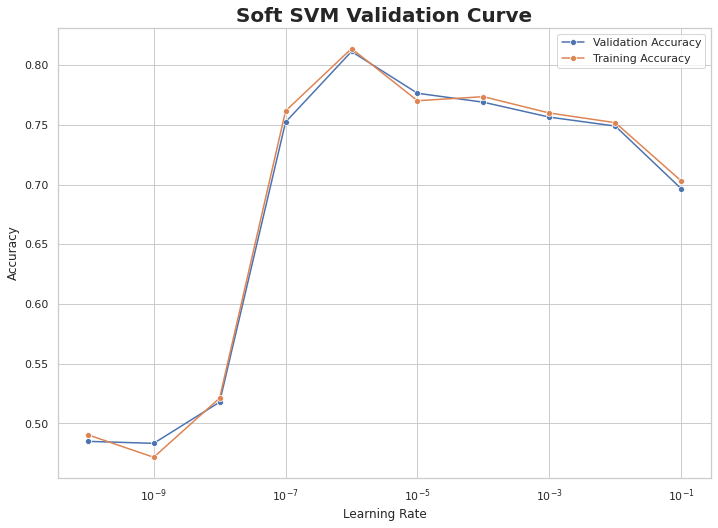

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
ax1 = sns.lineplot(x="Learning Rate", y="Validation Accuracy", data=to_plot, 
                   ci=None, label='Validation Accuracy', marker='o')
sns.lineplot(x="Learning Rate", y="Training Accuracy", data=to_plot, 
             ci=None, label='Training Accuracy', marker='o', ax=ax1)
ax1.set(xlabel='Learning Rate', ylabel='Accuracy', xscale='log')
ax1.legend()
plt.title('Soft SVM Validation Curve', fontsize=20, fontweight='bold')